In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
#tf.config.list_physical_devices()

### Load initial Dataset for Training

In [3]:
# X_idrees= np.load("videosdataset/X_idrees.npy")
# X_sittichai= np.load("videosdataset/X_sittichai.npy")
# X_MJR= np.load("videosdataset/X_MJR.npy")
# X_hamed= np.load("videosdataset/X_hamed.npy")

# print(X_idrees.shape)
# print(X_sittichai.shape)
# print(X_MJR.shape)
# print(X_hamed.shape)


In [2]:
# tot_vid= X_idrees.shape[0] + X_sittichai.shape[0] + X_MJR.shape[0] + X_hamed.shape[0]
# print(tot_vid)
# X= np.zeros(shape=(tot_vid, 75, 200, 200, 1))
# X[0:X_idrees.shape[0]]= X_idrees
# X[X_idrees.shape[0]:X_idrees.shape[0]+X_sittichai.shape[0]]= X_sittichai
# X[380:630]= X_MJR
# X[630:]= X_hamed
# np.save("X_all.npy",X)


In [4]:
X= np.load("X_all.npy")
X.shape

(890, 75, 200, 200, 1)

### Build the AutoEncoder

In [5]:

frame_tot= 75
frame_width= 200
frame_height= 200
frame_channel= 1 #we consider grayscale image

#encoder
encoder_input= tf.keras.layers.Input(shape=(frame_tot,frame_width,frame_height,frame_channel))
x= tf.keras.layers.Conv3D(filters=64, kernel_size=3, strides= (3, 2, 2), padding='same', activation='relu')(encoder_input)
x= tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=None, padding='valid')(x)
x= tf.keras.layers.Conv3D(filters=128, kernel_size=3, strides= (1, 1, 1), padding='same', activation='relu')(x)
enocder_output= tf.keras.layers.MaxPool3D(pool_size=(1, 1, 1), strides=None, padding='same')(x)
encoder= tf.keras.Model(inputs= encoder_input, outputs=enocder_output)

#decoder
decoder_input= tf.keras.layers.Conv3D(filters=128, kernel_size=3, strides= (1, 1, 1), padding='same', activation='relu')(enocder_output)
x= tf.keras.layers.Conv3DTranspose(filters=64, kernel_size=3, strides=(1, 2, 2), padding='same', activation='relu')(decoder_input)
decoder_output= tf.keras.layers.Conv3DTranspose(filters=1, kernel_size=3, strides=(3, 2, 2), padding='same', activation='relu')(x)

autoencoder= tf.keras.Model(inputs=encoder_input, outputs=decoder_output)
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 200, 200, 1)  0         
                             ]                                   
                                                                 
 conv3d_3 (Conv3D)           (None, 25, 100, 100, 64)  1792      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 25, 50, 50, 64)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 25, 50, 50, 128)   221312    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 25, 50, 50, 128)  0         
 3D)                                                             
                                                           

### Training

In [34]:

#Train on X_idrees
#autoencoder_hist= autoencoder.fit(x= X_idrees, y= X_idrees, batch_size=32, epochs=5, verbose='auto')

In [7]:
#Train on X_sittichai 
#loaded_hist= loaded.fit(x= X_sittichai, y= X_sittichai, batch_size=32, epochs=3, verbose='auto')

autoencoder= tf.keras.models.load_model("best_v2")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [9]:

autoencoder_hist= autoencoder.fit(x= X, y= X, validation_split=0.20, batch_size=1, epochs=3, verbose='auto', callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

2022-11-21 22:19:37.804006: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 8544000000 exceeds 10% of free system memory.


Epoch 1/3


2022-11-21 22:19:41.430142: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 8544000000 exceeds 10% of free system memory.


712/712 [==============================] - 952s 1s/step - loss: 0.0021 - val_loss: 0.0025
Epoch 2/3
712/712 [==============================] - 968s 1s/step - loss: 0.0021 - val_loss: 0.0024
Epoch 3/3
712/712 [==============================] - 975s 1s/step - loss: 0.0020 - val_loss: 0.0023


In [10]:
autoencoder.save("best_v3")

INFO:tensorflow:Assets written to: best_v3/assets


INFO:tensorflow:Assets written to: best_v3/assets


### Load the Trained Model

In [19]:
#X= np.load("videosdataset/X_hamed.npy") #load the Dataset
#loaded= tf.keras.models.load_model("model_v2") #Load the Model

### Get Predictions of Autoencoder

In [6]:
X_test= X[0:20]
print(X_test.shape)
#loaded_pred= loaded.predict(X_test)
autoencoder_pred= autoencoder.predict(X_test)

(20, 75, 200, 200, 1)
1/1 [==============================] - 10s 10s/step


### Plot the Original and Reconstructed Frames

Text(0.5, 1.0, 'Reconstructed Frame')

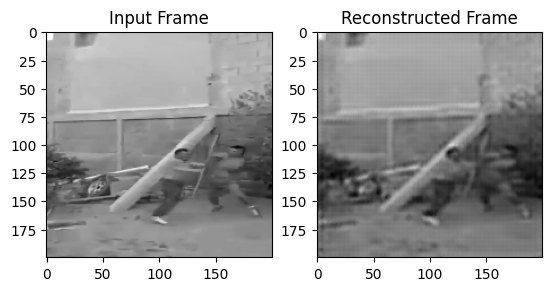

In [7]:
fig, ax= plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X_test[15,0], cmap='gray')
ax[1].imshow(autoencoder_pred[15,0], cmap='gray')
ax[0].set_title("Input Frame")
ax[1].set_title("Reconstructed Frame")


### Get Encoder Output for all dataSet

In [20]:
#make encoder model from the Loaded Model
enc_model= tf.keras.models.Sequential([loaded.layers[0], loaded.layers[1], loaded.layers[2], loaded.layers[3], loaded.layers[4]])
#enc_model.summary()
#set the weghts of the encoder
enc_model.layers[0].set_weights(loaded.layers[1].get_weights())
enc_model.layers[1].set_weights(loaded.layers[2].get_weights())
enc_model.layers[2].set_weights(loaded.layers[3].get_weights())
enc_model.layers[3].set_weights(loaded.layers[4].get_weights())

#rebuild the autoencoder model and set the weights
autoenc_model= tf.keras.models.Sequential([layer for layer in loaded.layers])
for idx, layer in enumerate(autoenc_model.layers, start=0):
    layer.set_weights(loaded.layers[idx+1].get_weights())

In [21]:
#encoded= enc_model.predict(X_test)
#print(encoded.shape)
recon_pred= autoenc_model.predict(X_test)
print(recon_pred.shape)

enc_pred= enc_model.predict(X_test)
print(enc_pred.shape)

1/1 [==============================] - 16s 16s/step
(9, 75, 200, 200, 1)
1/1 [==============================] - 3s 3s/step
(9, 25, 50, 50, 128)


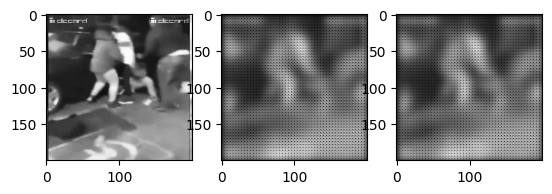

In [22]:
fig, ax= plt.subplots(nrows=1, ncols=3)
ax[0].imshow(X_test[0,30], cmap='gray')
ax[1].imshow(loaded_pred[0,30], cmap='gray')
ax[2].imshow(recon_pred[0,30], cmap='gray')


### Analyze the Encoded Ouputs

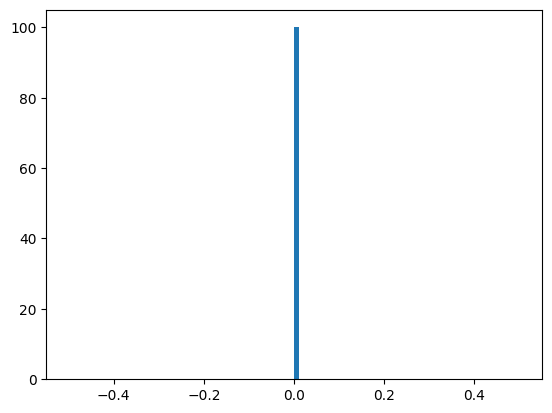

In [82]:
m= 0  #example nbr
t= 0  #frame nbr
ch= 127 #channel nbr

plt.hist(encoded[m,t,:,:,ch].flatten(), bins=100, density=True)
plt.show()

In [ ]:
loaded.summary()

In [92]:
del(loaded)

In [14]:
del(autoenc_model)